# Open Earth Foundation
## Open Ocean

This is the fourth of a series of 4 notebooks that explains step by step how to calculate the Marine Biodiversity Units applied to the Cocos Marine Conservation Area of Costa Rica

## Libraries

In [1]:
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [2]:
import fiona; #help(fiona.open)

In [3]:
%load_ext autoreload

In [4]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

## Data

Two data sources are used for these calculations, data from OBIS (observation points) and those from the IUCN red list (distribution polygons).

- Indices such as Shannon and Simpson can be calculated only with OBIS data
- Metrics like WEGE and Endemism can be calculated only with IUCN data
- Habitats accounting is calculating with IUCN Global Ecosystem Typology

**Accessing OBIS data**

OBIS data contains species information and points of observation

In [5]:
from pyobis import occurrences

In [6]:
# MPA file
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [7]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

query = occurrences.search(geometry=geometry)
query.execute()

# Returns the data
df2 = query.data 

4235 to be fetched. Estimated time =  4.165658904314041  89  seconds
Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4235/4235
Fetched 4235 records.


In [8]:
# convert OBIS dataframe to geodataframe
# making point with the lat and lon information
df2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.decimalLongitude, df2.decimalLatitude))

**Accesing IUCN RedList data**

In [9]:
#df1 = gpd.read_file('s3://ocean-program/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp')
df1 = gpd.read_file('s3://ocean-program/data/Test/gdf_range_status_filtered_shortV.shp')

**Accesing IUCN Global Ecosystem Typology**

For this step, it's needed only the ubication path of these files

In [10]:
#From AWS
s3 = boto3.resource('s3')
bucket = s3.Bucket('ocean-program')

eco_names = []

for obj in bucket.objects.filter(Prefix='data/raw/Ecosystems/'):
    name = obj.key[:]
    eco_names.append(f'https://ocean-program.s3.amazonaws.com/{name}')

## Marine Biodiveristy Units

In [11]:
# list of all modulating factors
MF = ['shannon_index','simpson_index','species_richness','endemism','wege','habitats_survey']

In [12]:
weights = {
    'shannon_index':1,
    'simpson_index':3,
    'species_richness':2,
    'endemism':6,
    'wege':4,
    'habitats_survey':5
}

In [13]:
baseline_value = 0.37

**IUCN Data**

In [14]:
MBUS_score_1 = total_mbu(MF, ACMC, df1, 'hexagon', 0.05, eco_names, 'IUCN', weights, baseline_value)

Calculating Shannon Index Modulating Factor
Calculating Habitats Survey Modulating Factor
Calculating WEGE Modulating Factor


/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:582: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MPA_area = MPA.area[0]
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:589: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  we = np.round(df.area/MPA_area, decimals=4, out=None)
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:200: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current 

Calculating Simpson Index Modulating Factor
Calculating Species Richness Modulating Factor


/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:143: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if this_row_boundary.type[:len('multi')].lower() == 'multi':
/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:164: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_gdf['geom_centroid'] = new_gdf.centroid


In [15]:
MBUS_score_1.head()

,geometry,Grid_ID,mbu_shannon_index,mbu_habitats_survey,wege,mbu_wege,mbu_simpson_index,mbu_species_richness,mbu_sum,result
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,0,0,NaN,NaN,0,NaN,0.0,1
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,0,0,NaN,NaN,0,NaN,0.0,1
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,0,0,NaN,NaN,0,NaN,0.0,1
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,0,0,NaN,NaN,0,NaN,0.0,1
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,0,0,NaN,NaN,0,NaN,0.0,1


Text(0.5, 1.0, 'Total amout of MBUs for ACMC\nSource: IUCN')

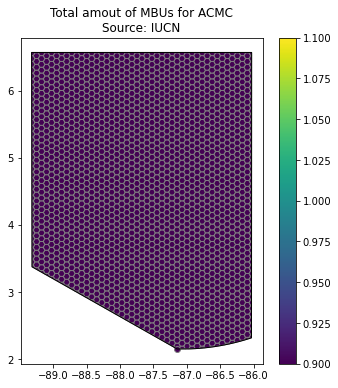

In [16]:
MBUS_score_1 = gpd.clip(MBUS_score_1.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = MBUS_score_1.plot(column='result', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Total amout of MBUs for ACMC\nSource: IUCN')

**OBIS Data**

In [17]:
MBUS_score_2 = total_mbu(MF, ACMC, df2, 'hexagon', 0.05, eco_names, 'OBIS', weights, baseline_value)

Calculating Shannon Index Modulating Factor


/Users/maureenfonseca/Documents/OEF/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:970: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  grid['mbu_shannon_index'] = mbu_shannon_index(MPA, gdf, grid, source)['mbu_shannon_index']*(1/weights.get('shannon_index'))
/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Calculating Habitats Survey Modulating Factor
Calculating WEGE Modulating Factor
Calculating Simpson Index Modulating Factor
Calculating Species Richness Modulating Factor


In [18]:
MBUS_score_2.head()

,geometry,Grid_ID,mbu_shannon_index,mbu_habitats_survey,mbu_wege,mbu_simpson_index,mbu_species_richness,mbu_sum,result
0,"POLYGON ((-89.27201 2.15063, -89.29701 2.19394...",0,NaN,0,0,NaN,0.00026,0.00026,1
1,"POLYGON ((-89.27201 2.23724, -89.29701 2.28054...",1,NaN,0,0,NaN,0.00026,0.00026,1
2,"POLYGON ((-89.27201 2.32384, -89.29701 2.36714...",2,NaN,0,0,NaN,0.00026,0.00026,1
3,"POLYGON ((-89.27201 2.41044, -89.29701 2.45374...",3,NaN,0,0,NaN,0.00026,0.00026,1
4,"POLYGON ((-89.27201 2.49704, -89.29701 2.54035...",4,NaN,0,0,NaN,0.00026,0.00026,1


Text(0.5, 1.0, 'Total amout of MBUs for ACMC\nSource: OBIS')

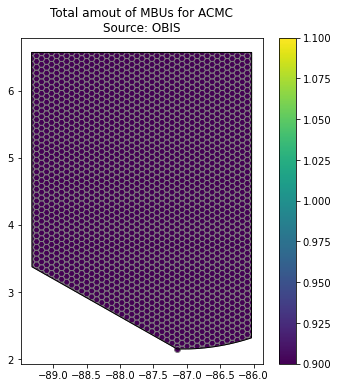

In [19]:
MBUS_score_2 = gpd.clip(MBUS_score_2.set_crs(epsg=4326, allow_override=True), ACMC.set_crs(epsg=4326, allow_override=True))
ax = MBUS_score_2.plot(column='result', figsize=(6, 6), cmap='viridis', edgecolor="grey", legend = True)

gpd.GeoSeries(ACMC.geometry).plot(ax=ax, edgecolor='black', facecolor='none', label='ACMC')
plt.title('Total amout of MBUs for ACMC\nSource: OBIS')